# Welcome to SImulation of SEctoral Pathways with Uncertainty Exploration for DEcarbonization (SISEPUEDE)

https://sisepuede.readthedocs.io/en/latest/


In [39]:
## load packages
import logging
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import temp as tmp
from sisepuede import *
from typing import *
import warnings
warnings.filterwarnings("ignore")

##
def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, os.path.join(os.getcwd(), "log_temp.log"))

<Logger __main__ (DEBUG)>

##  Initialize the SISEPUEDE class to get started running some models
- see ``?SISEPUEDE`` for more information on initialization arguments
- Initializing the class creates an output database and assigns the run a unique analysis id
- The database includes a number of tables, which can be accessed in python using the SISEPUEDE class
- Running the following cell will instantiate SISEPUEDE for Chile using the latest calibrated data (all subsectors)
- see ``?SISEPUEDE`` for more information on inputs

In [ ]:
# run to look at more information on inputs
?SISEPUEDE

In [2]:
# initialize the SISPEUEDE object for Chile using the latest calibrated data
sisepuede = SISEPUEDE(
    "calibrated", 
    logger = logger, 
    regions = ["chile"],
    instantiate_nemomod = False # for AFOLU only application, don't instantiate Julia (avoids requirement to install)
)


2023-02-01 10:56:07,778 - INFO - Successfully initialized SISEPUEDEFileStructure.
2023-02-01 10:56:07,779 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2023-02-01 10:56:07,780 - INFO - 	Setting export engine to 'sqlite'.
2023-02-01 10:56:07,802 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2023-02-01 10:56:07,803 - INFO - Successfully instantiated table ANALYSIS_METADATA
2023-02-01 10:56:07,805 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2023-02-01 10:56:07,805 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2023-02-01 10:56:07,807 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2023-02-01 10:56:07,808 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2023-02-01 10:56:07,810 - WARNING - No index

##  Where are the templates?
- The path to the templates can be found by running the cell below
- Templates are divded by model sector:
    - **AF** AFOLU
    - **CE** Circular Economy
    - **EN** Energy
    - **IP** Industrial Processes and Product Use
    - **SE** Socieoconomic
- Every subsector requires the socioconomic subsector and data from the input sector (e.g., AFOLU requires SE and AF). Some subsectors require additional data from upstream models.
- Each sheet in the template represents a strategy, with a name like "strategy_id-XX", which gives the inputs for strategy XX. Strategies beyond the baseline (0) *only need to include variables that are adjusted in that strategy* (as of 2023-02-01, see the EN for best example).
- Additionally, strategies **must** be defined in ``./docs/csvs/attribute_dim_strategy.csv``. This enables cross-sectoral strategies and provides a mechanism for coordinating systemic strategies (e.g., strategy 1 is the same strategy in AF as it is in CE). 
    - It is recommended that sector-specific strategies get indexed by an offset; e.g., 1001-1999 are AFOLU, 2001-2999 are CE, etc.



In [26]:
sisepuede.file_struct.dict_data_mode_to_template_directory.get(sisepuede.data_mode)

'/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/ingestion/calibrated'

##  Instantiating SISEPUEDE creates a unique session ID 
- look at `sisepuede.id` to find the unique analysis id associated with this id
- the id can be used to restore previous sessions if the database is still in place (**NOTE: THIS FUNCTIONALITY IS STILL BEING DEVELOPED**)

In [30]:
print(f"current id:\n\n\t{sisepuede.id}\n\n")

current id:

	sisepuede_run_2023-02-01T10:56:06.714469




###  Call the .project_scenarios() method to write outputs directly to a database (prevents significant memory usage)
- This method returns a list of primary keys that were successfully run
- Scenarios are dependent on several dimensions:
    - `design_id`: controls on Latin Hypercube (LHC) sampling 
    - `future_id`: the LHC sample, which represents a plausible future under uncertainty. 
        - **NOTE** The number of LHC samples is set in the config file, **sisepuede.config**
    - `strategy_id`: the strategy, or set of alternatives, that are being considered
- The scenarios are indexed in a single primary key, known as `primary_id`
- The first positional argument, ``primary_keys``, can be a list of primary keys *or* a dictionary of scenario dimensions
    - e.g., ``sisepuede.project_scenarios([0, 5, 1989])`` uses 3 primary keys
    - ``sisepuede.project_scenarios({"strategy_id": [0], "future_id": [0, 9, 903]})`` specifies a scenario dimensional subset of primary keys
- see ``?sisepuede.project_scenarios`` for more information on inputs

##  Let's start by running just the baseline
- baselines for each dimension are indexed by 0
- use ``.project_scenarios()`` method
- The SISEPUEDE database management system only overwrites a scenario if it does not exist in the database
    - E.g., if you run the model using a scenario (and it successfully writes to the database), SISEPUEDE defaults to **not** re-run the scenario and instead skip it 



In [32]:
# project across 2 futures for 1 design and, notably, *all* strategies (no filtering)
dict_filt = {
    "future_id": [0],
    "design_id": [0],
    "strategy_id": [0]
}

primary_keys_out = sisepuede.project_scenarios(
    dict_filt,
    chunk_size = 2
)

####  Print successfully completed primary keys

In [34]:
for k, v in primary_keys_out.items():
    v_out = ", ".join([str(x) for x in v])
    print(f"region: {k}\n\tprimary_keys complete: {v_out}")
    

region: chile
	primary_keys complete: 


###  Retrieve outputs using SISEPUEDE.read_output()
- if you don't specify primary keys or an indexing dictionary, 
- see ``?sisepuede.read_output`` for more

In [38]:
df_out = sisepuede.read_output(None)
df_out

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,chile,0,0.0,533718.011088,15431.885735,408513.474913,0.0,46123.262395,57908.334837,...,5.683725e+06,0.0,119497.301295,121970.877959,0.0,118297.969600,166845.738338,0.0,3.139779e+06,1.454261e+06
1,0,chile,1,0.0,541173.250605,15647.446016,414219.794989,0.0,46767.535141,58717.227356,...,5.918498e+06,0.0,120813.404342,121783.933328,0.0,132393.677361,160817.091467,0.0,3.278828e+06,1.486644e+06
2,0,chile,2,0.0,549186.020625,15879.126695,420352.854875,0.0,47459.988996,59586.611862,...,6.118763e+06,0.0,127207.008506,121217.044510,0.0,137900.109050,152016.964474,0.0,3.744598e+06,1.566927e+06
3,0,chile,3,0.0,557732.155361,16126.229045,426894.157821,0.0,48198.535582,60513.866370,...,6.572165e+06,0.0,146864.552808,123690.342860,0.0,140853.275677,165095.717248,0.0,3.904239e+06,1.557936e+06
4,0,chile,4,0.0,566788.054135,16388.070677,433825.639614,0.0,48981.135357,61496.430210,...,7.518148e+06,0.0,139596.235767,124481.074030,0.0,146427.298979,171213.596230,0.0,3.728976e+06,1.575977e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,904,chile,31,0.0,933580.947502,26993.495080,714572.843812,0.0,80678.931785,101293.411469,...,1.774511e+07,0.0,408615.698940,372852.806254,0.0,467702.352184,555037.687995,0.0,9.130011e+06,5.063701e+06
716,904,chile,32,0.0,949707.553968,27459.778666,726916.320909,0.0,82072.573532,103043.146174,...,1.834897e+07,0.0,424290.746965,387308.927589,0.0,486349.191630,577301.486756,0.0,9.448048e+06,5.266080e+06
717,904,chile,33,0.0,965919.036558,27928.516355,739324.763099,0.0,83473.550171,104802.089929,...,1.897334e+07,0.0,440459.543193,402217.434917,0.0,505569.710972,600247.723997,0.0,9.776729e+06,5.474676e+06
718,904,chile,34,0.0,982210.065325,28399.554036,751794.090784,0.0,84881.401094,106569.664432,...,1.961881e+07,0.0,457133.441668,417588.487852,0.0,525375.981002,623890.547438,0.0,1.011635e+07,5.689619e+06


##  Tables are indexed by primary_key and time_period. 
- ``time_period`` values are defined in ``docs/csvs/attribute_dim_time_period.csv``
- ``primary_id`` values are dynamic and unique to every session id (they represent the unique combination of ``design_id``, ``future_id``, and ``strategy_id``. 
- See ``?sisepuede.odpt_primary`` for information on accessing primary key indices
    - ODPT stands for Ordered Direct Product Table
    - an odpt_table is a virtual indexing table that efficiently indexes scenarios without storing the table to memory, which can become unteneble with a high number of futures and strategies



In [47]:
?sisepuede.odpt_primary

Type:        OrderedDirectProductTable
String form: <ordered_direct_product_table.OrderedDirectProductTable object at 0x13c1f5810>
File:        ~/Documents/Projects/git_jbus/lac_decarbonization/python/ordered_direct_product_table.py
Docstring:  
Define an index table to map the direct product of multiple dimensions to a
    key. Three key methods are available:

    * OrderedDirectProductTable.get_dims_from_key()
        Get dimensional values associated with a key (inverse of
            get_key_value)
    * OrderedDirectProductTable.get_key_value()
        Get a key value associated with dimensional values (inverse of
            get_dims_from_key)
    * OrderedDirectProductTable.get_indexing_dataframe()
        Get a data frame associated with select dimensional values or with
            key values.

Function Arguments
------------------
- dict_dims: dictionary mapping dimensions to all available values
- list_dims_ordered: list of available

Keyword Arguments
-----------------
- k

In [46]:
# print the inudexing table for available primary keys
sisepuede.odpt_primary.get_indexing_dataframe(
    sorted(list(df_out["primary_id"].unique()))
)

,primary_id,design_id,strategy_id,future_id
0,0,0,0,0
1,471,0,0,471
2,904,0,0,904
3,1001,0,1,0
4,2002,0,2,0
5,3003,0,1001,0
6,4004,0,2001,0
7,5005,0,3001,0
8,6006,0,3002,0
9,7007,0,3003,0


####  Note that SISEPUEDE.read_output() can be used to execute additional filtering queries by using dict_subset = {}
- e.g., if we only care about the final time period, we can set
    ``dict_subset = {"time_period": 35}``

In [42]:
sisepuede.read_output(
    None, 
    dict_subset = {"time_period": 35}
)

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
1,1001,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
2,2002,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
3,3003,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
4,4004,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
5,5005,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
6,6006,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
7,7007,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
8,8008,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06
9,9009,chile,35,0.0,998575.917086,28872.755145,764320.688788,0.0,86295.718129,108345.357221,...,2.447240e+07,0.0,454401.160448,405199.640109,0.0,476637.025432,557319.159675,0.0,1.213823e+07,5.129980e+06


In [52]:
# access only two scenarios and a selected subsect of years
df_red = sisepuede.read_output(
    None, 
    dict_subset = {
        "primary_id": [0, 15015],
        "time_period": [0, 10, 20, 30, 35]
    }
)

##  Finally, we can use model_attributes methods to simplify variable access
- Use sisepuede.model_attributes.get_standard_variables() to access variables by variable name (e.g., "Fuel Efficiency Gasoline" or "Change to Net Imports of Crops"
    - **NOTE** more shortcuts are in development to facilitate quicker access to variables in SISEPUEDE
    - Variables with gasses (like $\text{CO}_2$) are entered as (for example)
    
        - ":math:\\text{CH}_4 Emissions from Rice"
        - ":math:\\text{CO}_2 Emissions from Biomass Carbon Stock Changes"
        - ":math:\\text{N}_2\\text{O} Emissions from Crop Residues"
        
    - Variable names are found on Read The Docs (https://sisepuede.readthedocs.io/en/latest/) in attribute tables in the ``Variable`` column
        - some variables incude multiple categories, some do not
        
    - output variables are often in the units of the configuration file (e.g., emissions mass, area, length, energy, power, etc.) unless otherwise specified (this information is provided in the variable table that defines each variable--e.g., those under "Variables by Category" or those under "Variables by Partial Category"); see ``sisepuede.config`` and https://sisepuede.readthedocs.io/en/latest/analytical_parameters.html for more info. 

In [67]:
# see total area of each cropland type (in configuration units, which defaults to ha) under baseline (primary_key = 0) -- note: will need to concatenate time period and primary key to get those data
df_red = sisepuede.read_output([0])
var_extract = "Crop Area"
sisepuede.model_attributes.get_standard_variables(
    df_red, 
    var_extract
)

,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,area_agrc_crops_other_woody_perennial,area_agrc_crops_pulses,area_agrc_crops_rice,area_agrc_crops_sugar_cane,area_agrc_crops_tubers,area_agrc_crops_vegetables_and_vines
0,0.0,533718.011088,15431.885735,408513.474913,0.0,46123.262395,57908.334837,0.0,30758.702444,24190.358165,0.0,75183.518928,60120.904916
1,0.0,541173.250605,15647.446016,414219.794989,0.0,46767.535141,58717.227356,0.0,31188.355349,24528.261160,0.0,76233.719839,60960.703718
2,0.0,549186.020625,15879.126695,420352.854875,0.0,47459.988996,59586.611862,0.0,31650.139294,24891.433795,0.0,77362.458674,61863.305793
3,0.0,557732.155361,16126.229045,426894.157821,0.0,48198.535582,60513.866370,0.0,32142.661581,25278.780776,0.0,78566.331261,62825.988977
4,0.0,566788.054135,16388.070677,433825.639614,0.0,48981.135357,61496.430210,0.0,32664.562079,25689.232420,0.0,79842.013031,63846.094759
5,0.0,576329.804222,16663.960181,441128.997200,0.0,49805.721812,62531.708854,0.0,33214.462674,26121.704900,0.0,81186.135458,64920.929480
6,0.0,586335.794512,16953.272693,448787.689203,0.0,50670.427342,63617.357500,0.0,33791.117896,26575.218710,0.0,82595.654239,66048.058747
7,0.0,596784.084550,17255.373830,456784.922164,0.0,51573.355879,64750.995611,0.0,34393.263294,27048.779417,0.0,84067.478677,67225.011069
8,0.0,607653.315487,17569.646024,465104.347793,0.0,52512.661618,65930.305755,0.0,35019.667937,27541.418945,0.0,85598.600005,68449.380466
9,0.0,618922.709026,17895.488491,473730.062156,0.0,53486.548922,67153.033489,0.0,35669.134350,28052.195536,0.0,87186.091236,69718.826359


In [65]:
# see Crop Yield (in tonnes, as specified in the variable table)
var_extract = "Crop Yield"
df_red = sisepuede.read_output([0])
sisepuede.model_attributes.get_standard_variables(
    df_red, 
    var_extract
)

,yield_agrc_bevs_and_spices_tonne,yield_agrc_cereals_tonne,yield_agrc_fibers_tonne,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0.0,3.588346e+06,14070.793413,5.683725e+06,0.0,119497.301295,121970.877959,0.0,118297.969600,166845.738338,0.0,3.139779e+06,1.454261e+06
1,0.0,3.759591e+06,14142.944082,5.918498e+06,0.0,120813.404342,121783.933328,0.0,132393.677361,160817.091467,0.0,3.278828e+06,1.486644e+06
2,0.0,3.851524e+06,14638.966900,6.118763e+06,0.0,127207.008506,121217.044510,0.0,137900.109050,152016.964474,0.0,3.744598e+06,1.566927e+06
3,0.0,3.985477e+06,14693.413595,6.572165e+06,0.0,146864.552808,123690.342860,0.0,140853.275677,165095.717248,0.0,3.904239e+06,1.557936e+06
4,0.0,4.028184e+06,14927.074176,7.518148e+06,0.0,139596.235767,124481.074030,0.0,146427.298979,171213.596230,0.0,3.728976e+06,1.575977e+06
5,0.0,4.177917e+06,15481.935493,7.797608e+06,0.0,144785.233308,129108.218763,0.0,151870.217194,177577.857594,0.0,3.867588e+06,1.634559e+06
6,0.0,4.335462e+06,16065.740725,8.091647e+06,0.0,150244.910929,133976.734956,0.0,157597.061066,184274.105775,0.0,4.013430e+06,1.696196e+06
7,0.0,4.500972e+06,16679.066894,8.400554e+06,0.0,155980.664861,139091.434545,0.0,163613.490888,191308.959203,0.0,4.166646e+06,1.760950e+06
8,0.0,4.674608e+06,17322.499663,8.724624e+06,0.0,161997.972166,144457.201551,0.0,169925.251738,198689.135449,0.0,4.327384e+06,1.828883e+06
9,0.0,4.856528e+06,17996.633784,9.064157e+06,0.0,168302.394900,150078.995783,0.0,176538.177849,206421.456328,0.0,4.495792e+06,1.900057e+06


###  1. We can examine aggregate emissions across scenarios

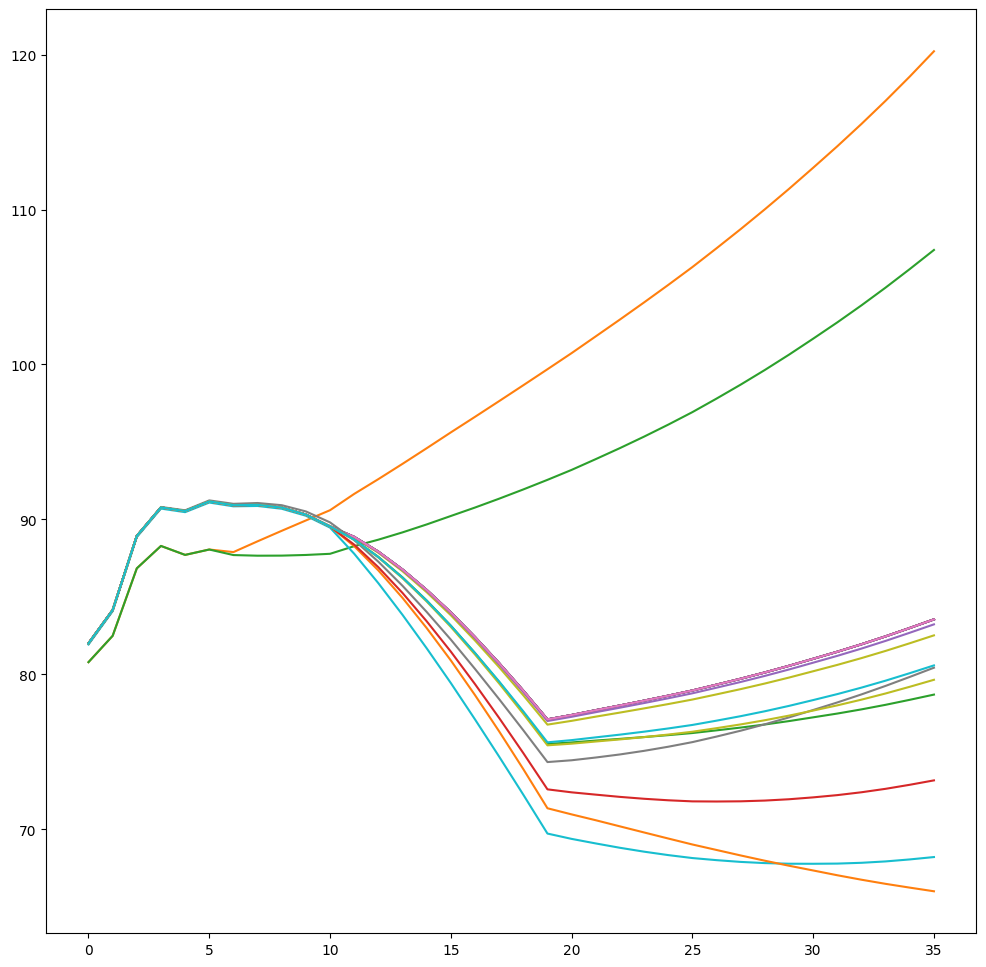

In [71]:
fig, ax = plt.subplots(figsize = (12, 12))
for i in sorted(list(df_out["primary_id"].unique())):
    
    df_cur = df_out[df_out["primary_id"] == i]
    
    y = np.array(df_cur[
        [x for x in df_out.columns if x.startswith("emission_co2e_subsector_")]
    ].sum(axis = 1)) 
    x = np.array(df_cur["time_period"])
    
    ax.plot(x, y)
    
plt.show()


###  2. We can also see CO2e by subsector

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'emission_co2e_subsector_total_soil' contains both positive and negative values

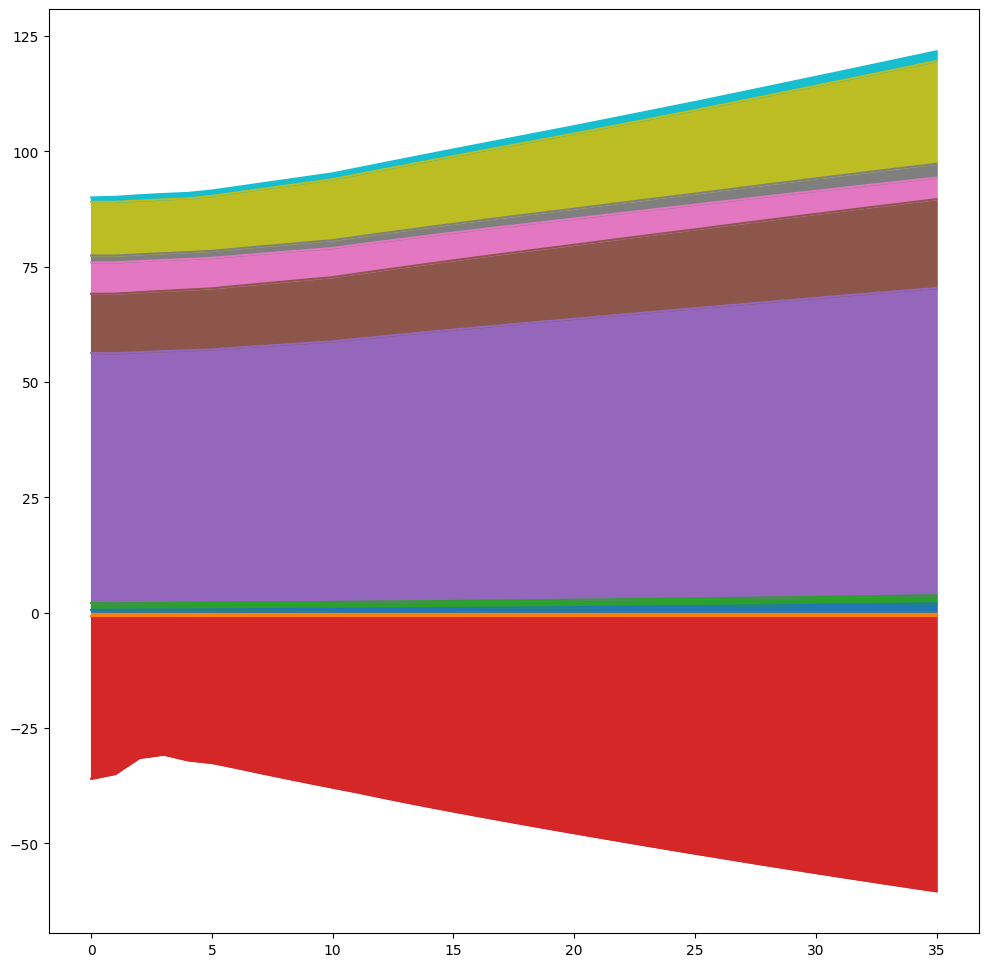

In [73]:
fig, ax = plt.subplots(figsize = (12, 12))
df_cur = df_out[df_out["primary_id"] == 0]
df_cur[[x for x in df_cur.columns if x.startswith("emission_co2e_subsector_total_")]].plot.area(ax = ax)
plt.show()


###  3a. We can go further down and look at gas within subsector - CH4 emisions in Livestock Manure Management (e.g.)

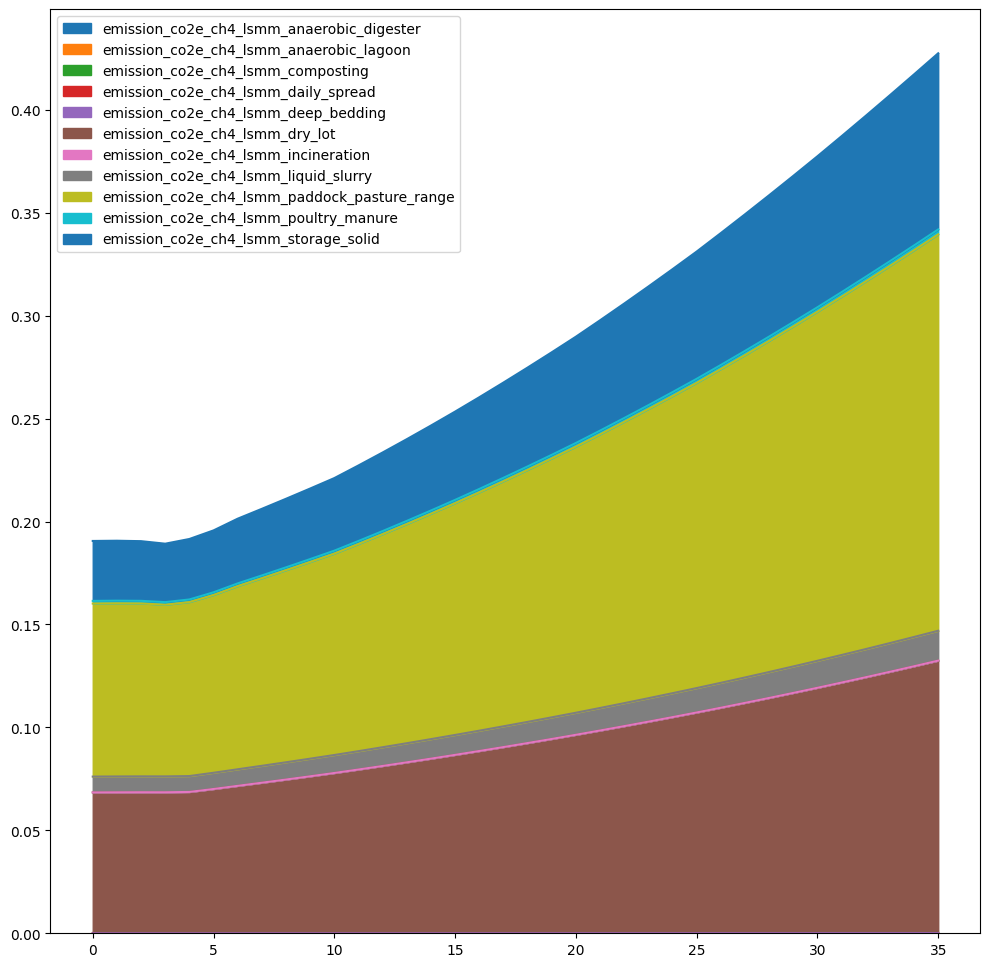

In [76]:
fig, ax = plt.subplots(figsize = (12, 12))
df_cur = df_out[df_out["primary_id"] == 0].reset_index(drop = True)
df_cur[[x for x in df_cur.columns if x.startswith("emission_co2e_ch4") and ("_lsmm_" in x)]].plot.area(ax = ax)
plt.show()


###  4. The land use reallocation factor affects land use, imports, and exports

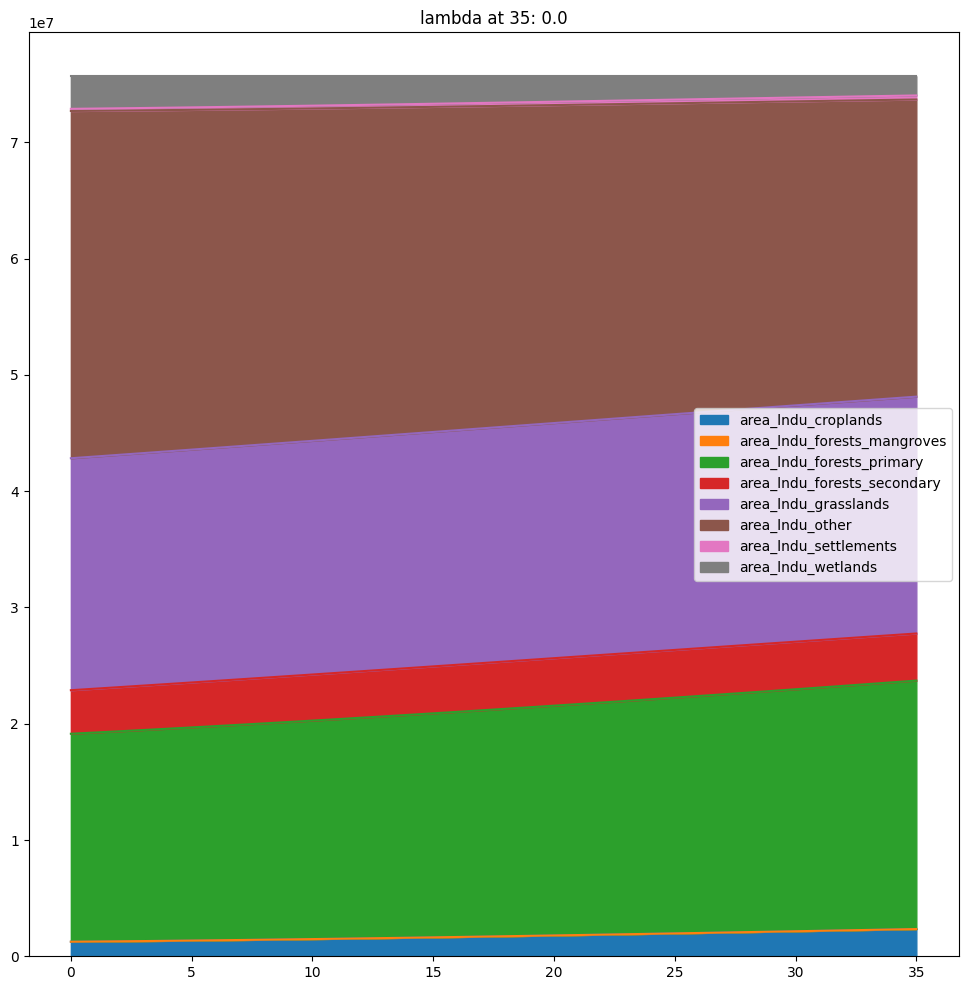

In [80]:
# NOTE: this is run statically, so the dynamics of the reallocation factor are not shown here
i = 0
fig, ax = plt.subplots(figsize = (12, 12))

df_cur = df_out[df_out["primary_id"] == i]
df_cur = sisepuede.model_attributes.get_standard_variables(df_cur, "Land Use Area", return_type = "data_frame")

val = sisepuede.generate_scenario_database_from_primary_key(i)["chile"]["lndu_reallocation_factor"].iloc[-1]

df_cur.plot.area(ax = ax)
ax.set_title(f"lambda at 35: {val}")

plt.show()
    
    